# Cat Breed Classifier

In [ ]:
!pip install --upgrade wandb

# Initiating Weights&Biases

In [2]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

In [ ]:
wandb.login()

In [4]:
configs={
        "layer_1": 256,
        "activation_1": "relu",
        "layer_2": 128,
        "activation_2": "relu",
        "dropout1": 0.5,
        "dropout2": 0.4,
        "layer_3": 19,
        "activation_3": "softmax",
        "regularization": 0.002,
        "optimizer": "RMSprop",
        "loss": "sparse_categorical_crossentropy",
        "metric": "accuracy",
        "epoch": 100,
        "batch_size": 64
    }

In [ ]:
# Start a run, tracking hyperparameters
wandb.init(
    project="catbreed_classifier_19",
    config=configs,
    reinit=True
)

# [optional] use wandb.config as your config
config = wandb.config

## Connecting to Drive


In [6]:
#assessing files from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!ls "/content/drive/My Drive/catbreedclassifier/images_cats/"

## Count my images

In [ ]:
import os

source_dir = "/content/drive/My Drive/catbreedclassifier/images_cats"

# Initialize a dictionary to hold the count of images in each subfolder
image_counts = {}

# Initialize a variable to hold the total count
total_images = 0

# Iterate over each subfolder
for breed_folder in os.listdir(source_dir):
    breed_path = os.path.join(source_dir, breed_folder)
    if os.path.isdir(breed_path):
        # Count the number of files in the subfolder
        num_images = len([name for name in os.listdir(breed_path) if os.path.isfile(os.path.join(breed_path, name))])
        image_counts[breed_folder] = num_images
        total_images += num_images

# Print the count for each subfolder
for breed, count in image_counts.items():
    print(f"{breed}: {count} images")

# Print the total count
print(f"Total images: {total_images}")


## Preparing the Images

In order for the images to be ready to be used in the models, we have to put them through a pre-processing phase. This includes reshaping them to (224, 224, 3) tensors as it is the recommended shape for the MobileNetV2 model input.

In [7]:
from PIL import Image, ImageOps
import numpy as np
import os
from tensorflow.keras.applications import mobilenet_v2

#oads an image from a given path, converts it to RGB,
#resizes or pads it to a specified size (default 224x224 for MobileNetV2),
#and then applies MobileNetV2-specific preprocessing
def load_and_preprocess_image(file_path, desired_size=224):
    with Image.open(file_path) as img:
        img = img.convert('RGB')  # Convert to RGB if not already
        # Check if image needs padding
        if img.size[0] < desired_size or img.size[1] < desired_size:
            img = pad_image(img, desired_size)
        else:
            img = img.resize((desired_size, desired_size), Image.Resampling.LANCZOS)

        img = np.array(img)
        img = mobilenet_v2.preprocess_input(img)  # Preprocess for MobileNetV2, scale input pixels between -1 and 1
        return img

#helper function used by load_and_preprocess_image to add padding to images
#that are smaller than the desired size
def pad_image(image, desired_size):
    old_size = image.size  # old_size is in (width, height) format
    delta_w = desired_size - old_size[0]
    delta_h = desired_size - old_size[1]
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
    return ImageOps.expand(image, padding)


#Data Augmentation

In [8]:
# data augmentation (not used)
def augment_image(image):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),  # Random horizontal flip
        #tf.keras.layers.RandomBrightness(0.3),  # Random brightness adjustment
        #tf.keras.layers.RandomContrast((0.8, 1.2)),  # Random contrast adjustment
        # tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),  # Random zoom
    ])
    # Add a batch dimension, apply augmentation, and then remove the batch dimension
    image = tf.expand_dims(image, 0)  # Add the batch dimension
    image = data_augmentation(image)  # Apply the augmentation
    image = tf.squeeze(image, 0)  # Remove the batch dimension
    return image

## Custom Data Generator

In [8]:
import numpy as np

#This generator function is designed to yield batches of preprocessed images and their corresponding labels.
#It shuffles the file paths and labels at the start of each epoch, then iterates over the dataset in batches,
#loading and preprocessing each image in the batch.
def image_generator(file_paths, labels, batch_size, augment=False):
    while True:  # Loop forever so the generator never terminates
        # Shuffle file paths and labels at the beginning of each epoch
        indices = np.arange(len(file_paths))
        np.random.shuffle(indices)
        file_paths = np.array(file_paths)[indices]
        labels = np.array(labels)[indices]

        for i in range(0, len(file_paths), batch_size):
            batch_paths = file_paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]

            images = []
            for path in batch_paths:
                # Load each image
                img = load_and_preprocess_image(path)
                # Apply augmentation if augment is True
                if augment:
                    img = augment_image(img)
                images.append(img)

            yield np.array(images), np.array(batch_labels)



## Prepare File Paths and Labels

https://www.forbes.com/advisor/pet-insurance/pet-care/popular-cat-breeds

In [9]:
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

source_dir = "/content/drive/My Drive/catbreedclassifier/images_cats"

# Define the 10 specific subfolders you want to include
specific_subfolders = ['Ragdoll', 'Maine Coon', 'Exotic Shorthair',
                       'Persian', 'Devon Rex',
                       'British Shorthair', 'Oriental Shorthair', 'Siamese', 'Cornish Rex',
                       'Abyssinian', 'American Shorthair', 'Scottish Fold', 'Sphynx', 'Norwegian Forest',
                       'Siberian cat', 'Sacred Birman', 'Russian Blue', 'Bengal', 'Selkirk Rex longhair']

# Generate file paths and labels
file_paths = []
labels = []

for breed_folder in specific_subfolders:
    breed_path = os.path.join(source_dir, breed_folder)
    all_files = os.listdir(breed_path)
    all_files.sort()  # Sort the files to maintain consistency
    selected_files = all_files[:150]  # Select only the first 100 files

    for filename in selected_files:
        file_path = os.path.join(breed_path, filename)
        file_paths.append(file_path)
        labels.append(breed_folder)

# Encode labels
le = LabelEncoder()
le.fit(labels)
encoded_labels = le.transform(labels)

# Split file paths and labels into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    file_paths, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)


In [12]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

## Define and Compile the Model

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to be monitored
    factor=0.1,          # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5           # Number of epochs with no improvement after which learning rate will be reduced.
)

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)



In [11]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers

tf.keras.backend.clear_session()

# loading pretrained model
base_net = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    pooling='max'
)

base_net.trainable = False

# build a model
model = models.Sequential([
    base_net,
    layers.Flatten(),
    layers.Dense(config.layer_1, activation=config.activation_1, kernel_regularizer=regularizers.L2(config.regularization)),
    layers.Dropout(config.dropout1),
    layers.Dense(config.layer_2, activation=config.activation_2, kernel_regularizer=regularizers.L2(config.regularization)),
    layers.Dropout(config.dropout2),
    layers.Dense(config.layer_3, activation=config.activation_3)
])

model.summary()

model.compile(optimizer=config.optimizer,
              loss=config.loss,
              metrics=[config.metric]
              )




9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0   

## Create Datasets and Train Model

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint
from wandb.keras import WandbCallback

batch_size = config.batch_size

train_gen = image_generator(X_train, y_train, batch_size, augment=False)
val_gen = image_generator(X_val, y_val, batch_size)

steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

# Define a ModelCheckpoint callback with SavedModel format
checkpoint_path = "models/checkpoint-{epoch:02d}"
checkpoint = ModelCheckpoint(checkpoint_path, save_weights_only=True, save_format='tf', verbose=1)

history = model.fit(
    train_gen,
    epochs=config.epoch,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[
        WandbCallback(),  # Automatically logs metrics and uploads model checkpoints
        checkpoint,       # Saves model checkpoints locally
        early_stopping,   # Early stopping to prevent overfitting
        reduce_lr         # Reduce learning rate when a metric has stopped improving
    ]
)

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()



wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
35/35 [==============================] - ETA: 0s - loss: 4.9965 - accuracy: 0.1147 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231223_151734-rqfjwz0e/files/model-best)... Done. 0.1s



Epoch 1: saving model to models/checkpoint-01
35/35 [==============================] - 531s 15s/step - loss: 4.9965 - accuracy: 0.1147 - val_loss: 3.7356 - val_accuracy: 0.2188 - lr: 0.0010
Epoch 2/100
35/35 [==============================] - ETA: 0s - loss: 3.6742 - accuracy: 0.1963

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231223_151734-rqfjwz0e/files/model-best)... Done. 0.1s



Epoch 2: saving model to models/checkpoint-02
35/35 [==============================] - 46s 1s/step - loss: 3.6742 - accuracy: 0.1963 - val_loss: 3.1138 - val_accuracy: 0.3242 - lr: 0.0010
Epoch 3/100
35/35 [==============================] - ETA: 0s - loss: 3.2262 - accuracy: 0.2671

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231223_151734-rqfjwz0e/files/model-best)... Done. 0.1s



Epoch 3: saving model to models/checkpoint-03
35/35 [==============================] - 47s 1s/step - loss: 3.2262 - accuracy: 0.2671 - val_loss: 2.4426 - val_accuracy: 0.4805 - lr: 0.0010
Epoch 4/100
35/35 [==============================] - ETA: 0s - loss: 2.6684 - accuracy: 0.3642

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231223_151734-rqfjwz0e/files/model-best)... Done. 0.1s



Epoch 4: saving model to models/checkpoint-04
35/35 [==============================] - 51s 1s/step - loss: 2.6684 - accuracy: 0.3642 - val_loss: 2.0137 - val_accuracy: 0.5469 - lr: 0.0010
Epoch 5/100
35/35 [==============================] - ETA: 0s - loss: 2.2846 - accuracy: 0.4106

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231223_151734-rqfjwz0e/files/model-best)... Done. 0.1s



Epoch 5: saving model to models/checkpoint-05
35/35 [==============================] - 47s 1s/step - loss: 2.2846 - accuracy: 0.4106 - val_loss: 1.7733 - val_accuracy: 0.6016 - lr: 0.0010
Epoch 6/100
35/35 [==============================] - ETA: 0s - loss: 2.0962 - accuracy: 0.4594

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231223_151734-rqfjwz0e/files/model-best)... Done. 0.1s



Epoch 6: saving model to models/checkpoint-06
35/35 [==============================] - 41s 1s/step - loss: 2.0962 - accuracy: 0.4594 - val_loss: 1.5912 - val_accuracy: 0.6191 - lr: 0.0010
Epoch 7/100
35/35 [==============================] - ETA: 0s - loss: 1.9015 - accuracy: 0.4955

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231223_151734-rqfjwz0e/files/model-best)... Done. 0.1s



Epoch 7: saving model to models/checkpoint-07
35/35 [==============================] - 44s 1s/step - loss: 1.9015 - accuracy: 0.4955 - val_loss: 1.4409 - val_accuracy: 0.6543 - lr: 0.0010
Epoch 8/100
35/35 [==============================] - ETA: 0s - loss: 1.7723 - accuracy: 0.5316
Epoch 8: saving model to models/checkpoint-08
35/35 [==============================] - 14s 409ms/step - loss: 1.7723 - accuracy: 0.5316 - val_loss: 1.4418 - val_accuracy: 0.6348 - lr: 0.0010
Epoch 9/100
35/35 [==============================] - ETA: 0s - loss: 1.6357 - accuracy: 0.5587

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231223_151734-rqfjwz0e/files/model-best)... Done. 0.1s



Epoch 9: saving model to models/checkpoint-09
35/35 [==============================] - 51s 1s/step - loss: 1.6357 - accuracy: 0.5587 - val_loss: 1.2550 - val_accuracy: 0.6738 - lr: 0.0010
Epoch 10/100
35/35 [==============================] - ETA: 0s - loss: 1.5190 - accuracy: 0.5871

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231223_151734-rqfjwz0e/files/model-best)... Done. 0.2s



Epoch 10: saving model to models/checkpoint-10
35/35 [==============================] - 42s 1s/step - loss: 1.5190 - accuracy: 0.5871 - val_loss: 1.2402 - val_accuracy: 0.6855 - lr: 0.0010
Epoch 11/100
35/35 [==============================] - ETA: 0s - loss: 1.5054 - accuracy: 0.5907

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231223_151734-rqfjwz0e/files/model-best)... Done. 0.1s



Epoch 11: saving model to models/checkpoint-11
35/35 [==============================] - 45s 1s/step - loss: 1.5054 - accuracy: 0.5907 - val_loss: 1.1713 - val_accuracy: 0.7070 - lr: 0.0010
Epoch 12/100
35/35 [==============================] - ETA: 0s - loss: 1.3822 - accuracy: 0.6273

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231223_151734-rqfjwz0e/files/model-best)... Done. 0.1s



Epoch 12: saving model to models/checkpoint-12
35/35 [==============================] - 40s 1s/step - loss: 1.3822 - accuracy: 0.6273 - val_loss: 1.1447 - val_accuracy: 0.6914 - lr: 0.0010
Epoch 13/100
35/35 [==============================] - ETA: 0s - loss: 1.3292 - accuracy: 0.6403

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231223_151734-rqfjwz0e/files/model-best)... Done. 0.1s



Epoch 13: saving model to models/checkpoint-13
35/35 [==============================] - 48s 1s/step - loss: 1.3292 - accuracy: 0.6403 - val_loss: 1.0960 - val_accuracy: 0.7051 - lr: 0.0010
Epoch 14/100
35/35 [==============================] - ETA: 0s - loss: 1.2761 - accuracy: 0.6638
Epoch 14: saving model to models/checkpoint-14
35/35 [==============================] - 14s 401ms/step - loss: 1.2761 - accuracy: 0.6638 - val_loss: 1.1297 - val_accuracy: 0.7207 - lr: 0.0010
Epoch 15/100
35/35 [==============================] - ETA: 0s - loss: 1.2267 - accuracy: 0.6737
Epoch 15: saving model to models/checkpoint-15
35/35 [==============================] - 25s 738ms/step - loss: 1.2267 - accuracy: 0.6737 - val_loss: 1.1246 - val_accuracy: 0.7129 - lr: 0.0010
Epoch 16/100
35/35 [==============================] - ETA: 0s - loss: 1.2080 - accuracy: 0.6764
Epoch 16: saving model to models/checkpoint-16
35/35 [==============================] - 23s 687ms/step - loss: 1.2080 - accuracy: 0.6764 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231223_151734-rqfjwz0e/files/model-best)... Done. 0.1s



Epoch 17: saving model to models/checkpoint-17
35/35 [==============================] - 48s 1s/step - loss: 1.1533 - accuracy: 0.6918 - val_loss: 1.0113 - val_accuracy: 0.7422 - lr: 0.0010
Epoch 18/100
35/35 [==============================] - ETA: 0s - loss: 1.0771 - accuracy: 0.7189
Epoch 18: saving model to models/checkpoint-18
35/35 [==============================] - 19s 559ms/step - loss: 1.0771 - accuracy: 0.7189 - val_loss: 1.0581 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 19/100
35/35 [==============================] - ETA: 0s - loss: 1.0953 - accuracy: 0.7067

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231223_151734-rqfjwz0e/files/model-best)... Done. 0.1s



Epoch 19: saving model to models/checkpoint-19
35/35 [==============================] - 49s 1s/step - loss: 1.0953 - accuracy: 0.7067 - val_loss: 0.9806 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 20/100
35/35 [==============================] - ETA: 0s - loss: 1.0620 - accuracy: 0.7256

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231223_151734-rqfjwz0e/files/model-best)... Done. 0.1s



Epoch 20: saving model to models/checkpoint-20
35/35 [==============================] - 40s 1s/step - loss: 1.0620 - accuracy: 0.7256 - val_loss: 0.9421 - val_accuracy: 0.7598 - lr: 0.0010
Epoch 21/100
35/35 [==============================] - ETA: 0s - loss: 1.0145 - accuracy: 0.7392
Epoch 21: saving model to models/checkpoint-21
35/35 [==============================] - 16s 470ms/step - loss: 1.0145 - accuracy: 0.7392 - val_loss: 1.0154 - val_accuracy: 0.7598 - lr: 0.0010
Epoch 22/100
35/35 [==============================] - ETA: 0s - loss: 0.9891 - accuracy: 0.7491
Epoch 22: saving model to models/checkpoint-22
35/35 [==============================] - 25s 743ms/step - loss: 0.9891 - accuracy: 0.7491 - val_loss: 0.9460 - val_accuracy: 0.7832 - lr: 0.0010
Epoch 23/100
35/35 [==============================] - ETA: 0s - loss: 0.9713 - accuracy: 0.7604
Epoch 23: saving model to models/checkpoint-23
35/35 [==============================] - 26s 761ms/step - loss: 0.9713 - accuracy: 0.7604 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231223_151734-rqfjwz0e/files/model-best)... Done. 0.1s



Epoch 24: saving model to models/checkpoint-24
35/35 [==============================] - 51s 1s/step - loss: 0.9603 - accuracy: 0.7523 - val_loss: 0.9234 - val_accuracy: 0.7930 - lr: 0.0010
Epoch 25/100
35/35 [==============================] - ETA: 0s - loss: 0.9132 - accuracy: 0.7717
Epoch 25: saving model to models/checkpoint-25
35/35 [==============================] - 16s 474ms/step - loss: 0.9132 - accuracy: 0.7717 - val_loss: 0.9291 - val_accuracy: 0.7949 - lr: 0.0010
Epoch 26/100
35/35 [==============================] - ETA: 0s - loss: 0.9112 - accuracy: 0.7847

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231223_151734-rqfjwz0e/files/model-best)... Done. 0.1s



Epoch 26: saving model to models/checkpoint-26
35/35 [==============================] - 51s 1s/step - loss: 0.9112 - accuracy: 0.7847 - val_loss: 0.8912 - val_accuracy: 0.7969 - lr: 0.0010
Epoch 27/100
35/35 [==============================] - ETA: 0s - loss: 0.8680 - accuracy: 0.7811
Epoch 27: saving model to models/checkpoint-27
35/35 [==============================] - 17s 495ms/step - loss: 0.8680 - accuracy: 0.7811 - val_loss: 0.9187 - val_accuracy: 0.8145 - lr: 0.0010
Epoch 28/100
35/35 [==============================] - ETA: 0s - loss: 0.8400 - accuracy: 0.7960
Epoch 28: saving model to models/checkpoint-28
35/35 [==============================] - 27s 777ms/step - loss: 0.8400 - accuracy: 0.7960 - val_loss: 0.9456 - val_accuracy: 0.7969 - lr: 0.0010
Epoch 29/100
35/35 [==============================] - ETA: 0s - loss: 0.8489 - accuracy: 0.7951
Epoch 29: saving model to models/checkpoint-29
35/35 [==============================] - 23s 677ms/step - loss: 0.8489 - accuracy: 0.7951 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231223_151734-rqfjwz0e/files/model-best)... Done. 0.1s



Epoch 32: saving model to models/checkpoint-32
35/35 [==============================] - 53s 2s/step - loss: 0.7285 - accuracy: 0.8326 - val_loss: 0.8490 - val_accuracy: 0.8320 - lr: 1.0000e-04
Epoch 33/100
35/35 [==============================] - ETA: 0s - loss: 0.6209 - accuracy: 0.8732
Epoch 33: saving model to models/checkpoint-33
35/35 [==============================] - 16s 463ms/step - loss: 0.6209 - accuracy: 0.8732 - val_loss: 0.8625 - val_accuracy: 0.8438 - lr: 1.0000e-04
Epoch 34/100
35/35 [==============================] - ETA: 0s - loss: 0.6107 - accuracy: 0.8696
Epoch 34: saving model to models/checkpoint-34
35/35 [==============================] - 24s 689ms/step - loss: 0.6107 - accuracy: 0.8696 - val_loss: 0.8622 - val_accuracy: 0.8379 - lr: 1.0000e-04
Epoch 35/100
35/35 [==============================] - ETA: 0s - loss: 0.6381 - accuracy: 0.8664

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231223_151734-rqfjwz0e/files/model-best)... Done. 0.1s



Epoch 35: saving model to models/checkpoint-35
35/35 [==============================] - 52s 2s/step - loss: 0.6381 - accuracy: 0.8664 - val_loss: 0.8329 - val_accuracy: 0.8457 - lr: 1.0000e-04
Epoch 36/100
35/35 [==============================] - ETA: 0s - loss: 0.6350 - accuracy: 0.8574
Epoch 36: saving model to models/checkpoint-36
35/35 [==============================] - 16s 460ms/step - loss: 0.6350 - accuracy: 0.8574 - val_loss: 0.8659 - val_accuracy: 0.8398 - lr: 1.0000e-04
Epoch 37/100
35/35 [==============================] - ETA: 0s - loss: 0.6059 - accuracy: 0.8768
Epoch 37: saving model to models/checkpoint-37
35/35 [==============================] - 25s 730ms/step - loss: 0.6059 - accuracy: 0.8768 - val_loss: 0.8360 - val_accuracy: 0.8477 - lr: 1.0000e-04
Epoch 38/100
35/35 [==============================] - ETA: 0s - loss: 0.5836 - accuracy: 0.8831
Epoch 38: saving model to models/checkpoint-38
35/35 [==============================] - 26s 775ms/step - loss: 0.5836 - accura

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231223_151734-rqfjwz0e/files/model-best)... Done. 0.1s



Epoch 41: saving model to models/checkpoint-41
35/35 [==============================] - 50s 1s/step - loss: 0.5887 - accuracy: 0.8705 - val_loss: 0.8235 - val_accuracy: 0.8418 - lr: 1.0000e-05
Epoch 42/100
35/35 [==============================] - ETA: 0s - loss: 0.5945 - accuracy: 0.8800
Epoch 42: saving model to models/checkpoint-42
35/35 [==============================] - 16s 479ms/step - loss: 0.5945 - accuracy: 0.8800 - val_loss: 0.8670 - val_accuracy: 0.8320 - lr: 1.0000e-05
Epoch 43/100
35/35 [==============================] - ETA: 0s - loss: 0.5844 - accuracy: 0.8804

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231223_151734-rqfjwz0e/files/model-best)... Done. 0.1s



Epoch 43: saving model to models/checkpoint-43
35/35 [==============================] - 49s 1s/step - loss: 0.5844 - accuracy: 0.8804 - val_loss: 0.8155 - val_accuracy: 0.8438 - lr: 1.0000e-05
Epoch 44/100
35/35 [==============================] - ETA: 0s - loss: 0.5876 - accuracy: 0.8831
Epoch 44: saving model to models/checkpoint-44
35/35 [==============================] - 16s 458ms/step - loss: 0.5876 - accuracy: 0.8831 - val_loss: 0.8375 - val_accuracy: 0.8379 - lr: 1.0000e-05
Epoch 45/100
35/35 [==============================] - ETA: 0s - loss: 0.5787 - accuracy: 0.8822
Epoch 45: saving model to models/checkpoint-45
35/35 [==============================] - 27s 788ms/step - loss: 0.5787 - accuracy: 0.8822 - val_loss: 0.8232 - val_accuracy: 0.8398 - lr: 1.0000e-05
Epoch 46/100
35/35 [==============================] - ETA: 0s - loss: 0.5712 - accuracy: 0.8827
Epoch 46: saving model to models/checkpoint-46
35/35 [==============================] - 26s 772ms/step - loss: 0.5712 - accura

accuracy,▁▂▂▄▄▄▅▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇█▇▇▇████████████████
val_loss,█▇▅▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.88357
best_epoch,42
best_val_loss,0.81551
epoch,52
loss,0.5838
val_accuracy,0.83789


In [13]:
# For training accuracy
best_training_accuracy = max(history.history['accuracy'])

# For validation accuracy
best_validation_accuracy = max(history.history['val_accuracy'])

print(f"Best training accuracy: {best_training_accuracy}")
print(f"Best validation accuracy: {best_validation_accuracy}")

Best training accuracy: 0.8862816095352173
Best validation accuracy: 0.8515625


In [14]:
val_accuracy_per_epoch = history.history['val_accuracy']
# For highest accuracy
best_epoch = np.argmax(val_accuracy_per_epoch)
best_epoch

50

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import load_model



# Load the best weights into the model
model.load_weights("/content/wandb/latest-run/files/model-best.h5")

# Load and preprocess all validation data
X_val_preprocessed = np.array([load_and_preprocess_image(path) for path in X_val])
y_val_array = np.array(y_val)  # Assuming y_val is already a list or similar array-like structure

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_array)

# Get the model's predictions
predicted_probabilities = model.predict(X_val_preprocessed)
predicted_labels = np.argmax(predicted_probabilities, axis=1)





In [16]:
from sklearn.metrics import classification_report

classes = le.classes_

# Assuming y_val is your true labels and classes are the class names
print(classification_report(y_val, predicted_labels, target_names=classes))


                      precision    recall  f1-score   support

          Abyssinian       1.00      1.00      1.00        30
  American Shorthair       0.77      0.57      0.65        30
              Bengal       1.00      0.93      0.97        30
   British Shorthair       0.62      0.67      0.65        30
         Cornish Rex       0.87      0.87      0.87        30
           Devon Rex       0.89      0.83      0.86        30
    Exotic Shorthair       0.77      0.77      0.77        30
          Maine Coon       0.82      0.90      0.86        30
    Norwegian Forest       0.79      0.73      0.76        30
  Oriental Shorthair       0.90      0.90      0.90        30
             Persian       0.81      0.87      0.84        30
             Ragdoll       0.81      0.73      0.77        30
        Russian Blue       0.81      0.87      0.84        30
       Sacred Birman       0.72      0.93      0.81        30
       Scottish Fold       0.88      0.77      0.82        30
Selkirk

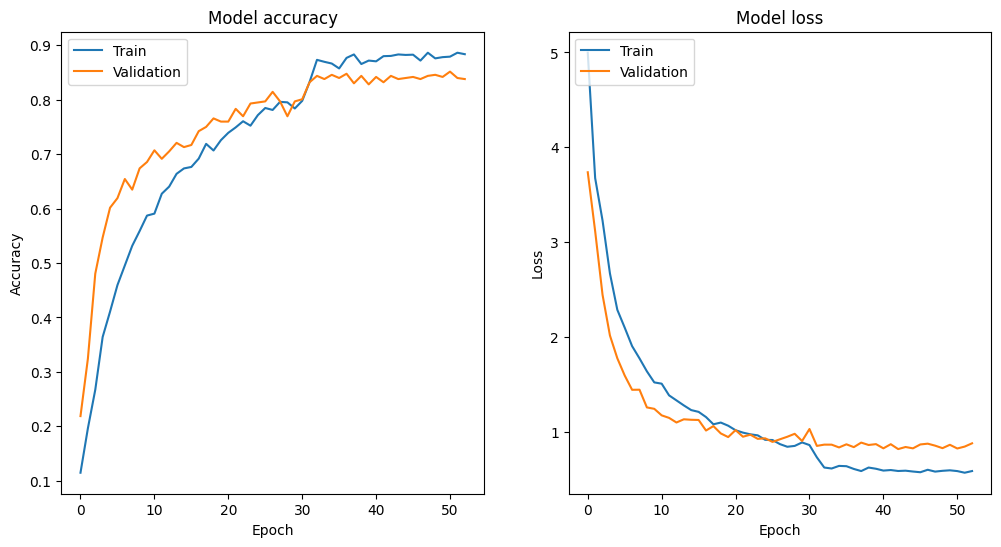

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Plotting training & validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()




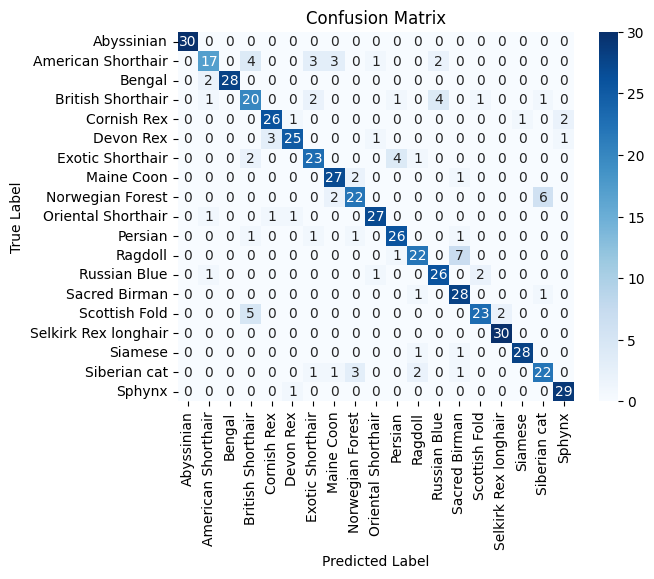

In [18]:
# Confusion Matrix
conf_mat = confusion_matrix(y_val, predicted_labels)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()